In [1]:
# Implementation of face recognition using neural net 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

Using TensorFlow backend.


## This notebook as been tested with :
* Python 3.5
* Keras 2
* TensorFlow

In [4]:
from keras import backend as K
K.set_image_data_format( 'channels_last' ) # WARNING : important for images and tensors dimensions ordering

## Build model architecture

In [5]:
def vgg_face_blank():
    
    model = Sequential()
    model.add( Permute((1,2,3), input_shape=(224,224,3)) )
    
    model.add(Convolution2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1'))
    model.add(Convolution2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1'))
    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_1'))
    model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_2'))
    model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_1'))
    model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_2'))
    model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_1'))
    model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_2'))
    model.add(Convolution2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Add another conv layer with ReLU + GAP
    model.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6')) 
    model.add( Dropout(0.5))
    model.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7'))
    model.add( Dropout(0.5))
    model.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8'))
    model.add( Flatten())
    model.add( Activation('softmax'))

    return model

In [7]:
facemodel = vgg_face_blank()

In [8]:
# facemodel.summary() # visual inspection of model architecture

In [9]:
facemodel.load_weights('VGG16_face.h5')
description = np.load('classes.npy')

### Test on squared and well centered image

In [10]:
im = Image.open('ak.png') # WARNING : this image is well centered and square
im = im.resize((224,224))

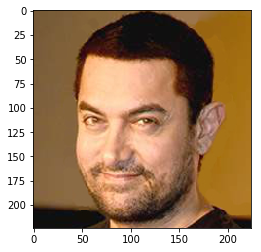

In [11]:
plt.imshow(np.asarray(im))

In [12]:
def pred(im):
    imarr = np.array(im).astype(np.float32)
    imarr = np.expand_dims(imarr, axis=0)
    out = facemodel.predict(imarr)

    best_index = np.argmax(out, axis=1)[0]
    best_name = description[best_index,0]
    print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])
    
pred(im)

2 Aamir_Khan 0.994438 [9.476131e-09, 0.99443793]


## Face extraction + Face identification
#### This requires OpenCV :
https://pypi.python.org/pypi/opencv-python
#### See this tutorial on face CascadeClassifier :
https://realpython.com/blog/python/face-recognition-with-python/

In [17]:
import cv2

In [105]:
# imagePath = 'jakel.jpg'
imagePath = 'Glenister.jpg'
# imagePath = 'Aamir_Khan.jpg'
#imagePath = 'mzaradzki.jpg'
#imagePath = 'hugh_laurie.jpg'
#imagePath = 'Colin_Firth.jpg'
#imagePath = 'someguy.jpg'

In [106]:
def process_image(img):
    faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    faces = faceCascade.detectMultiScale(gray, 1.2, 5)
    img_crp = img[faces[0][0] : faces[0][0] + faces[0][2], faces[0][1]: faces[0][1] + faces[0][3],:]
    img_face = cv2.resize(img_crp,(224,224))
    return img_face

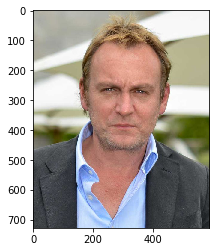

In [107]:
im = cv2.imread(imagePath)
cv_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)

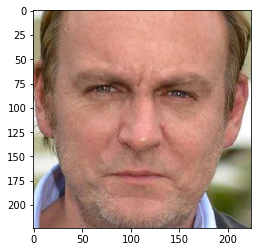

In [108]:
im = process_image(im)
cv_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(np.asarray(cv_rgb))

In [109]:
pred(im)

1996 Philip_Glenister 0.965512 [9.24884e-10, 0.96551228]


## Face Feature Vector : drop the last layer

In [22]:
featuremodel = Model(inputs=facemodel.layers[0].input, outputs=facemodel.layers[-2].output)

In [53]:
def features(featmodel, crpimg):
    
    imarr = np.array(crpimg).astype(np.float32)

    #imarr = imarr.transpose((2,0,1))
    imarr = np.expand_dims(imarr, axis=0)

    fvec = featmodel.predict(imarr)[0,:]
    # normalize
    normfvec = math.sqrt(fvec.dot(fvec))
    return fvec/normfvec

In [54]:
f = features(featuremodel, im)

In [55]:
f.shape, f.dot(f)

((2622,), 1.0000001)

In [57]:
def load_and_process(fp):
    im = cv2.imread(fp)
    im = process_image(im)
    return im

In [61]:
# f_jake = features(featuremodel, load_and_process('jakel.jpg'))
# f_jake_2 = features(featuremodel, im)
# f_morph = features(featuremodel, im)
# f_stew = features(featuremodel, load_and_process('stewa.jpg'))

## Scatch up
_TODO_ not working with large images need to reduce the size of them.

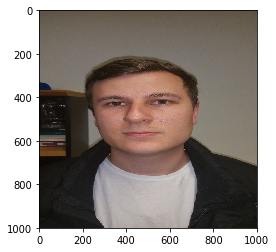

In [98]:
im = cv2.imread('stewa.jpg')
im = cv2.resize(im,(1000,1000))
cv_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)

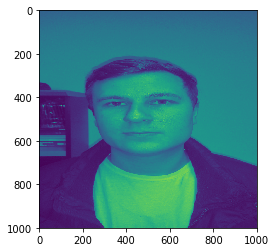

In [99]:
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)
faces = faceCascade.detectMultiScale(gray, 1.2, 5)

In [100]:
im.shape

(1000, 1000, 3)

In [101]:
faces[0][0]

269

In [102]:
img_crp = im[faces[0][0] : faces[0][0] + faces[0][2], faces[0][1]: faces[0][1] + faces[0][3],:]
img_face = cv2.resize(img_crp,(224,224))

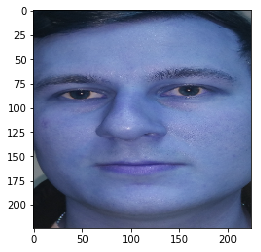

In [103]:
plt.imshow(img_face)

In [104]:
pred(img_face)

199 Ben_McKenzie 0.144735 [3.8238639e-05, 0.14473516]


## References
https://aboveintelligent.com/face-recognition-with-keras-and-opencv-2baf2a83b799
https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78